# Taller: Predicción de Series Temporales con Redes Neuronales (LSTM, CNN) en PyTorch

## Introducción
En este taller práctico aprenderemos a predecir series temporales utilizando distintos tipos de redes neuronales implementadas en PyTorch. En particular, exploraremos y compararemos tres enfoques de modelado:
* Un Perceptrón Multicapa (Multi-Layer Perceptron, MLP) tradicional.

* Una Red Neuronal Recurrente LSTM (Long Short-Term Memory), adecuada para datos secuenciales.
* Una Red Neuronal Convolucional (CNN) aplicada a series temporales (con convoluciones 1D).

Usaremos datos económicos reales (ejemplo: tasas de interés, inflación) obtenidos de fuentes públicas mediante librerías Python como pandas-datareader o fredapi. Incorporaremos además **variables categóricas** (como el día de la semana) mediante codificación one-hot, junto con variables numéricas (valores históricos de la serie), demostrando cómo manejar **variables mixtas** en nuestros modelos.

A lo largo del taller, seguiremos estos pasos generales:

- **Obtención de datos reales**: descargaremos una serie temporal financiera (p. ej., tasa de interés) usando fuentes de datos públicas gratuitas.
- **Preparación de datos**: crearemos un conjunto de datos supervisado a partir de la serie temporal, incluyendo lags (valores rezagados t-1, t-2, t-3) como características, y codificaremos variables categóricas (como el día de la semana) con one-hot encoding.

* **Construcción de modelos**: definiremos en PyTorch un modelo MLP, una red LSTM y una CNN 1D para realizar la predicción un paso adelante de la serie.

- **Entrenamiento de los modelos**: entrenaremos cada modelo con los datos preparados, incluyendo el proceso de instalación de dependencias y explicando cada segmento de código.

- **Evaluación del desempeño**: evaluaremos los modelos en un conjunto de prueba usando métricas adecuadas. Para regresión utilizaremos MAE (error absoluto medio) y RMSE (raíz del error cuadrático medio). Si tuviéramos un caso de clasificación, ilustraríamos el uso de matriz de confusión y curvas ROC, según corresponda.
- **Comparativa y conclusiones**: analizaremos los resultados obtenidos, destacando diferencias de desempeño y comportamiento entre el MLP tradicional, la LSTM y la CNN en el contexto de series temporales financieras.

Al finalizar, el estudiante comprenderá mejor cómo aplicar redes neuronales a problemas de pronóstico financiero y cuándo una arquitectura puede superar a otra en este contexto.

# 1. Instalación y Configuración de Entorno

Comenzamos asegurando que todas las dependencias necesarias estén instaladas. Esto incluye librerías para obtener datos, manipularlos y construir los modelos. Si estamos ejecutando en Google Colab, muchas librerías (como PyTorch) ya vienen preinstaladas. Aun así, mostraremos cómo instalarlas explícitamente por completitud:

In [ ]:
# Instalación de librerías necesarias (ejecutar si no están instaladas)
!pip install pandas_datareader fredapi matplotlib scikit-learn torch torchvision torchaudio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 22.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 29.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 33.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

- pandas_datareader y fredapi nos permitirán descargar datos económicos de fuentes públicas (por ejemplo, FRED - Federal Reserve Economic Data).
- matplotlib se usará para graficar la serie temporal y las predicciones.
- scikit-learn proporcionará funciones para el procesamiento de datos (p. ej. escalado) y métricas de evaluación.
- torch, torchvision, torchaudio son los paquetes de PyTorch (el core y módulos relacionados).

Aclaración: Si ejecutas este notebook en Google Colab, asegúrate de seleccionar un entorno de ejecución con Python 3 y GPU activada si planeas acelerar el entrenamiento (aunque para este ejemplo no es estrictamente necesario GPU debido a que las redes serán pequeñas).


# 2. Obtención de Datos Económicos Reales
Para ilustrar el taller, utilizaremos una serie temporal financiera real. Es importante escoger una serie con suficiente historial y variabilidad. Como ejemplo, usaremos la tasa de interés de los bonos del Tesoro de EE.UU. a 10 años (también conocida como *10-Year Treasury Constant Maturity Rate*). Esta serie es de frecuencia diaria (días hábiles) y está disponible públicamente en FRED bajo el código **"DGS10"**.

También podríamos haber elegido una serie de inflación (por ejemplo, la variación mensual del IPC), pero con datos diarios podemos mostrar el uso de la variable categórica "día de la semana" en la predicción.

Utilizaremos pandas_datareader para descargar la serie desde FRED. En caso de usar fredapi, se requeriría una clave de API, por lo que pandas_datareader resulta más sencillo para este taller.

Veamos cómo obtener los datos:

In [ ]:
import pandas as pd
from pandas_datareader import data as pdr
import datetime
import numpy as np


# Definir el período de tiempo para la serie temporal (ejemplo: 10 años de datos)
start_date = datetime.datetime(2010, 1, 1)
end_date   = datetime.datetime(2024, 12, 31)

# Descargar la serie de tasa de interés a 10 años (DGS10) desde FRED
df = pdr.DataReader('DGS10', 'fred', start_date, end_date)

# Mostrar las primeras y últimas filas para verificar
print("Datos descargados:")
print(df.head(5))
print("...")
print(df.tail(5))


Datos descargados:
            DGS10
DATE             
2010-01-01    NaN
2010-01-04   3.85
2010-01-05   3.77
2010-01-06   3.85
2010-01-07   3.85
...
            DGS10
DATE             
2024-12-25    NaN
2024-12-26   4.58
2024-12-27   4.62
2024-12-30   4.55
2024-12-31   4.58


### Explicación:

Establecemos **start_date** y **end_date** para definir el rango histórico de datos que queremos (en este caso, 2010-2020).
Usamos DataReader con el código `'DGS10'` y fuente `'fred'` para obtener la serie. Esto nos devuelve un DataFrame df con un índice de fechas y una columna con los valores de la tasa de interés.
Imprimimos las primeras y últimas filas para inspeccionar rápidamente el contenido.


En este ejemplo, la columna se llama `"DGS10"` y contiene la tasa de interés porcentual diaria. Observamos que en fechas como 2020-12-25 aparece **NaN **(datos faltantes). Esto ocurre típicamente en días feriados o fines de semana donde no hay cotización (FRED marca los días sin datos con NaN).

## 2.1 Limpieza y exploración inicial de los datos
Antes de profundizar, manejemos los datos faltantes y visualicemos la serie temporal:

Total de registros después de eliminar NaN: 3752
            DGS10
DATE             
2010-01-04   3.85
2010-01-05   3.77
2010-01-06   3.85
            DGS10
DATE             
2024-12-27   4.62
2024-12-30   4.55
2024-12-31   4.58


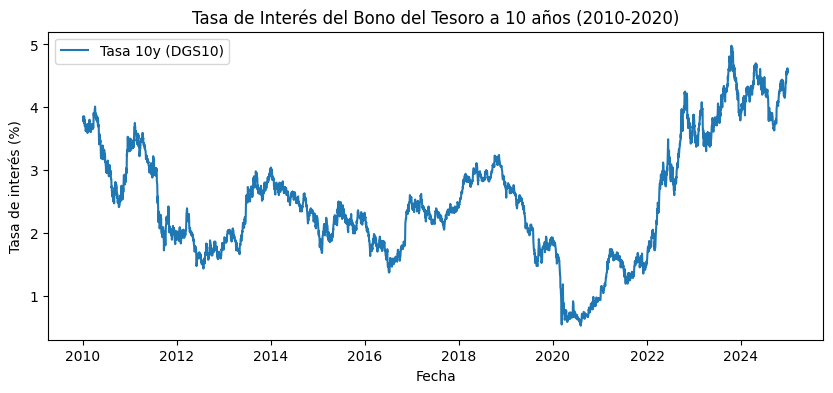

In [ ]:
# Eliminar filas con datos faltantes (NaN), típicos de fines de semana/feriados sin cotización
df = df.dropna()

print(f"Total de registros después de eliminar NaN: {len(df)}")
print(df.head(3))
print(df.tail(3))

# Graficar la serie temporal para visualizarla
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.plot(df.index, df['DGS10'], label='Tasa 10y (DGS10)')
plt.title('Tasa de Interés del Bono del Tesoro a 10 años (2010-2020)')
plt.xlabel('Fecha')
plt.ylabel('Tasa de interés (%)')
plt.legend()
plt.show()


### Explicación:

Utilizamos dropna() para eliminar cualquier fila con NaN. Alternativamente, podríamos interpolar o llenar con el último valor conocido, pero para simplificar el entrenamiento (y dado que los NaN corresponden a días sin actividad), los removemos. Así nuestros datos quedan con frecuencia de días hábiles.

Imprimimos de nuevo un par de filas iniciales y finales para confirmar que no quedan NaN.

Graficamos la serie con matplotlib para entender su comportamiento visualmente (tendencias, volatilidad, etc.). Esto nos da contexto sobre la tarea de predicción.

Al graficar, deberíamos ver la evolución de la tasa de interés en el período elegido, por ejemplo, subidas y bajadas a lo largo de los años (picos alrededor de 2018 cerca de 3%, caídas hacia 2020 por debajo de 1%, etc.).

# 3. Preparación de los Datos para el Modelo
Los modelos de redes neuronales no pueden trabajar directamente con la serie cruda para pronóstico. Necesitamos transformar la serie temporal en un conjunto de datos supervisado de la forma X -> y, donde X son las características **(features)** y y el valor a predecir **(label)**.

Para predecir la tasa de interés del día t (valor objetivo y), usaremos como features datos conocidos hasta el día t-1. Según lo solicitado, incluiremos:

- Lags **(rezagos)**: los valores de la serie en días previos, por ejemplo: t-1, t-2, t-3.
- **Variables categórica**: información del calendario, como el día de la semana del día t (que queremos predecir). Esta variable es conocida de antemano (podemos saber qué día de la semana será t), por lo que es razonable utilizarla como predictor. La codificaremos en formato one-hot (es decir, 7 columnas binarias representando Lunes, Martes, ..., Domingo).

Con esto, cada instancia de entrenamiento representará "usa los valores de los últimos 3 días y el indicador de qué día será hoy para predecir el valor de hoy".

## 3.1 Generación de características de rezago (lags)
Creamos nuevas columnas en el DataFrame para los lags:

In [ ]:
# Crear columnas de lags t-1, t-2, t-3
df['lag1'] = df['DGS10'].shift(1)
df['lag2'] = df['DGS10'].shift(2)
df['lag3'] = df['DGS10'].shift(3)

# Crear columna con el día de la semana de la fecha (0=Lunes, 6=Domingo)
df['dia_semana'] = df.index.weekday  # Monday=0, Sunday=6

# Eliminar filas iniciales con NaN generados por los lags
df = df.dropna()
print("Columnas del DataFrame después de añadir lags y día de semana:")
print(df.head(3))


Columnas del DataFrame después de añadir lags y día de semana:
            DGS10  lag1  lag2  lag3  dia_semana
DATE                                           
2010-01-07   3.85  3.85  3.77  3.85           3
2010-01-08   3.83  3.85  3.85  3.77           4
2010-01-11   3.85  3.83  3.85  3.85           0


### Explicación:
- `shift(1)` desplaza la serie una posición hacia adelante, de forma que en la fila con fecha t, `lag1` contiene el valor de` DGS10` en t-1. Hacemos lo mismo para lag2 y lag3.

- `index.weekday` nos da el número de día de la semana de cada fecha (lunes=0, ..., domingo=6). Guardamos eso en la columna **dia_semana**. (Alternativamente, `index.dayofweek` funciona igual.)

- Después de crear lags, las primeras 3 filas no tendrán valores válidos para lag1/lag2/lag3 (porque no existen días anteriores suficientes), resultando en NaN. Eliminamos esas filas con `dropna()` de nuevo.

- Ahora *df* contiene columnas: **DGS10** (valor actual), `lag1, lag2, lag3, dia_semana` para cada fecha (excepto las primeras 3 que se eliminaron).

## 3.2 One-Hot encoding de la variable categórica
La columna **dia_semana** es numérica (0-6) pero representa una categoría. Usaremos codificación one-hot para convertirla en variables dummys. Esto significa crear 7 columnas (una por cada día de la semana) con valores 0/1 indicando el día.

En nuestro dataset, cabe notar que la serie es de días hábiles, por lo que no tendremos muestras con día de semana = **5 o 6** (sábado, domingo) ya que no hay cotización esos días. Aun así, incluiremos las 7 categorías por generalidad.

Usaremos `pd.get_dummies` para esta transformación:

In [ ]:
# Aplicar one-hot encoding a la columna dia_semana
dummies = pd.get_dummies(df['dia_semana'], prefix='diasem', drop_first=False)
df_model = pd.concat([df, dummies], axis=1)

# Verificar resultado de one-hot encoding, solo para los días presentes en los datos
print("Ejemplo de one-hot encoding de día de semana:")
print(df_model[['dia_semana','diasem_0','diasem_1','diasem_2','diasem_3','diasem_4']].head(3)) # Only include days 0-4

Ejemplo de one-hot encoding de día de semana:
            dia_semana  diasem_0  diasem_1  diasem_2  diasem_3  diasem_4
DATE                                                                    
2010-01-07           3     False     False     False      True     False
2010-01-08           4     False     False     False     False      True
2010-01-11           0      True     False     False     False     False


### Explicación:
- `pd.get_dummies(..., prefix='diasem') `crea columnas `diasem_0` ... `diasem_6` correspondientes a cada valor posible. Cada fila tendrá 1 en la columna del día correspondiente y 0 en las demás.

- Concatenamos estas columnas dummy al DataFrame original `(pd.concat([...], axis=1))`.

- Imprimimos unas filas para verificar. Por ejemplo, si `dia_semana = 0 (lunes) `en una fila, veremos `diasem_0=1` y los demás `diasem_1 ... diasem_6 = 0`.

Ahora, df_model contiene todas las características necesarias. Las columnas relevantes para el modelo serán:

- `lag1`, `lag2`, `lag3` (tres últimas observaciones numéricas).
`diasem_0` ... `diasem_6` (variables indicadoras del día de la semana del día objetivo).
- La columna objetivo (que queremos predecir) será el valor actual `DGS10`. Sin embargo, atención: si estamos usando `lag1`, `lag2`, `lag3` para predecir el valor actual, entonces al entrenar nuestro modelo, `X = [lag1, lag2, lag3, one-hot del día actual]` e `y = DGS10 actual`.
## 3.3 División en conjunto de entrenamiento y prueba
Para evaluar el desempeño del modelo necesitaremos separar datos de **entrenamiento** (training) y de **prueba** (testing). Dado que se trata de una serie temporal, la separación debe respetar el orden temporal (no usaremos aleatorización, ya que eso podría causar leakage de información futura en el entrenamiento).

Dividiremos la serie de modo que las últimas fechas se reserven para prueba. Por ejemplo, usaremos datos hasta el año 2018 inclusive para entrenar, y dejaremos aproximadamente 2 años (2019-2020) para probar.

In [ ]:
# Determinar índice de corte para ~80% entrenamiento, 20% prueba (división temporal)
train_frac = 0.8
train_size = int(len(df_model) * train_frac)
train_df = df_model.iloc[:train_size]
test_df  = df_model.iloc[train_size:]

print(f"Datos de entrenamiento: {len(train_df)} muestras")
print(f"Datos de prueba: {len(test_df)} muestras")

# Separar features X y target y para entrenamiento y prueba
# Check for existing columns in the dataframes
features = [col for col in ['lag1','lag2','lag3','diasem_0','diasem_1','diasem_2','diasem_3','diasem_4','diasem_5','diasem_6'] if col in train_df.columns] # Filter features based on existing columns
target = 'DGS10'

X_train = train_df[features].values
y_train = train_df[target].values
X_test  = test_df[features].values # Use the same filtered features for test data
y_test  = test_df[target].values


Datos de entrenamiento: 2999 muestras
Datos de prueba: 750 muestras


### Explicación:
- Calculamos `train_size` como el 80% del total de muestras. Luego tomamos las primeras `train_size` filas como conjunto de entrenamiento, y el resto como prueba. Esto respeta la secuencia temporal.

- Definimos la lista de nombres de columnas que serán las features de entrada al modelo (`features` incluye 3 lags + 7 dummies de día de semana = 10 features en total). La variable **target** es `'DGS10'`.

- Creamos matrices numpy `X_train`, `y_train`, `X_test`,` y_test` extrayendo los valores (`.values`) de las respectivas columnas del DataFrame. Estas matrices serán usadas para entrenar y evaluar los modelos.

## 3.4 Escalado de características (normalización)
Es buena práctica normalizar o escalar los datos antes de entrenar redes neuronales, especialmente cuando se combinan variables de diferentes escalas (nuestros lags están en unidades de porcentaje de interés, ~0 a 5, mientras que los one-hot son 0/1). La normalización mejora la velocidad de convergencia y a veces el desempeño.

Usaremos **Min-Max scaling** para escalar los valores numéricos de entrada (lags) al rango [0,1]. También escalaremos la variable objetivo` DGS10` para que la red aprenda más fácilmente las variaciones (luego convertiremos la predicción de vuelta a escala original). Las variables one-hot no necesitan escalado (ya son 0/1).

**Nota**: Podríamos optar por Standardization (restar media y dividir por desviación estándar) en lugar de min-max. Cualquier método es válido; aquí usamos min-max por simplicidad de interpretación.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Inicializar escaladores
scaler_X = MinMaxScaler(feature_range=(0,1))
scaler_y = MinMaxScaler(feature_range=(0,1))

# Ajustar escalador de X solo con datos de entrenamiento (para evitar look-ahead bias)
# Importante: solo escalamos las columnas de lags, no las dummies (estas ya están entre 0 y 1).
scaler_X.fit(train_df[['lag1','lag2','lag3']])

# Aplicar transformacion a lags de entrenamiento y prueba
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_train_scaled[:, :3] = scaler_X.transform(X_train[:, :3])
X_test_scaled[:, :3] = scaler_X.transform(X_test[:, :3])

# Ajustar y aplicar escalador de y (target)
scaler_y.fit(train_df[['DGS10']])
y_train_scaled = scaler_y.transform(y_train.reshape(-1,1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1,1)).flatten()


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


### Explicación:
Creamos dos escaladores `MinMaxScaler:` uno para X y otro para y.

- Ajustamos `scaler_X` **sólo con datos de entrenamiento** `(fit(train_df[['lag1','lag2','lag3']]))`. Esto es crucial: el modelo no debe conocer estadísticas del conjunto de prueba durante el entrenamiento. (Las columnas dummy se omiten en el escalado ya que no requieren cambio.)

- Transformamos las matrices de entrada: copiamos `X_train` y `X_test` a nuevas variables `X_train_scaled`, `X_test_scaled` y reemplazamos las columnas 0:3 (los lags) con sus valores escalados.

- Para el objetivo `y`, ajustamos `scaler_y` con los valores de` DGS10` de entrenamiento, luego transformamos `y_train` y `y_test`. Obtenemos `y_train_scaled`, `y_test_scaled` listos para usar en la red.

- Al final de este proceso, tanto las características numéricas como el target están en el rango [0,1]. (Las dummy remain 0/1, ya dentro de ese rango.)


Ahora nuestros datos están listos: `X_train_scaled` (shape `[num_train_samples, 10 features]`), `y_train_scaled` (valor escala 0-1), y análogamente para prueba.

## 4. Construcción de los Modelos de Redes Neuronales
Pasaremos ahora a definir los tres modelos en PyTorch: MLP, LSTM y CNN. Antes de implementar cada uno, expliquemos brevemente sus características en este contexto:

- **Perceptrón Multicapa (MLP):** una red neuronal feed-forward tradicional que tomará el vector de características de entrada (los 3 lags + 7 one-hots) y producirá una predicción. No tiene memoria interna de secuencia; aprende relaciones estáticas entre las features y el target.

- **Red LSTM**: un tipo de red recurrente especializada en secuencias largas. Le pasaremos la secuencia temporal de lags como entrada (ej. los últimos 3 valores uno tras otro) y la red mantendrá un estado interno que puede ayudarla a capturar dependencias temporales. Combinaremos la salida de la LSTM con la variable categórica (día de la semana) para predecir el valor.

- **Red CNN 1D**: usaremos una red convolucional que aplica filtros sobre la secuencia de lags para extraer patrones locales (por ejemplo, tendencias entre días consecutivos). Luego, combinaremos esas características con la variable categórica y usaremos una capa densa para la predicción.

# 4.1 Modelo Perceptrón Multicapa (MLP)
Nuestro MLP será relativamente sencillo: tomará un vector de 10 entradas (3 lags + 7 dummies) y pasará por una o dos capas ocultas totalmente conectadas (fully connected), usando una función de activación no lineal (ReLU), para finalmente producir un único valor de salida (la predicción de la tasa de interés normalizada).

Definamos el modelo MLP en PyTorch:

In [ ]:
import torch
import torch.nn as nn

# Definir el modelo MLP
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(MLP, self).__init__()
        # Capa oculta
        self.hidden = nn.Linear(input_dim, hidden_dim)
        # Capa de salida
        self.out = nn.Linear(hidden_dim, 1)
        # Función de activación
        self.act = nn.ReLU()

    def forward(self, x):
        # x tiene forma [batch_size, input_dim]
        h = self.act(self.hidden(x))
        y_pred = self.out(h)
        return y_pred

# Inicializar MLP con dimensiones
input_dim = X_train_scaled.shape[1]   # debería ser 10
hidden_dim = 20  # escogemos 16 neuronas en la capa oculta (hiperparámetro ajustable)
model_mlp = MLP(input_dim, hidden_dim)
print(model_mlp)


MLP(
  (hidden): Linear(in_features=8, out_features=20, bias=True)
  (out): Linear(in_features=20, out_features=1, bias=True)
  (act): ReLU()
)


### Explicación:
- Creamos una clase` MLP` que hereda de `nn.Module`. En el `__init__` definimos las capas:

 - `hidden`: una capa lineal de **input_dim** (10) a **hidden_dim** neuronas (hemos elegido 16 arbitrariamente como ejemplo).
 - `out`: capa lineal de `hidden_dim `a 1 (la predicción).
 - `act`: la función de activación ReLU que aplicaremos entre la capa oculta y la de salida.
- En `forward`, definimos la propagación:

 - `x` es el tensor de entrada de tamaño `[batch_size, 10]`.
 - Aplicamos la capa oculta seguida de ReLU: `h = self.act(self.hidden(x))`.
 - Luego sacamos la predicción lineal: `y_pred = self.out(h)` (tendrá tamaño `[batch_size, 1]`).
- Creamos una instancia `model_mlp`. Imprimimos `model_mlp` para ver la estructura (PyTorch implementa `__repr__ `para mostrar las capas).


Podríamos agregar más capas ocultas o neuronas si quisiéramos un modelo más complejo, pero para este ejercicio lo mantendremos así.

## 4.2 Modelo LSTM para serie temporal
El modelo LSTM necesita manejar secuencias. En nuestro caso, la secuencia de entrada será la serie de los últimos 3 valores (lags) para cada predicción.

A diferencia del MLP, la LSTM leerá los valores uno por uno en orden temporal y mantendrá un estado interno (memoria) mientras avanza. Una vez procesados los 3 pasos de la secuencia, la LSTM producirá una representación (estado oculto final) que usaremos para predecir el valor.

Adicionalmente, queremos incorporar la variable categórica "día de la semana" del día objetivo. Una forma sencilla es:

1. Procesar la secuencia de valores con la LSTM.
2. Tomar la salida oculta final de la LSTM (un vector).
3. Concatenar este vector con la representación one-hot del día de la semana.
4. Pasar todo junto por una capa lineal final para obtener la predicción.


Vamos a implementar esta arquitectura. Primero, necesitamos dar forma a nuestros datos para la LSTM:

- PyTorch LSTM espera input de forma `(seq_len, batch, input_size)` por defecto, o `(batch, seq_len, input_size)` si especificamos `batch_first=True`.

- Es más intuitivo usar `batch_first=True`. Entonces cada entrada X a la LSTM tendrá forma `[batch_size, seq_len, input_size]`.
- En nuestro caso, `seq_len = 3` (los pasos t-3, t-2, t-1) y `input_size = 1` (una característica por paso: el valor de la serie).

- ¿Por qué 1? Porque vamos a dejar que la LSTM vea solo la secuencia de valores. (También podríamos alimentarla con más características por paso si tuviéramos, pero las únicas variables cambiantes con el tiempo en nuestro problema son los valores de la serie; la categórica es estática para la predicción.)

Preparamos los tensores para LSTM:

In [ ]:
# Convertir los datos escalados a tensores de PyTorch
X_train_tensor = torch.tensor(X_train_scaled.astype(np.float32), dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled.astype(np.float32), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32)

# Reformatear X para LSTM: de [batch, features] a [batch, seq_len, input_size]
# En X_train_scaled, las primeras 3 columnas son los lags; las columnas 3-9 son las dummies.
# Para LSTM, tomaremos sólo los lags como secuencia de longitud 3, y manejaremos las dummies por separado.
seq_len = 3
# Extraer las columnas de lags como secuencia
X_train_seq = X_train_tensor[:, :seq_len]  # shape [batch, 3]
X_test_seq = X_test_tensor[:, :seq_len]
# Añadir dimensión de input_size=1 para cada valor
X_train_seq = X_train_seq.unsqueeze(2)  # shape [batch, 3, 1]
X_test_seq = X_test_seq.unsqueeze(2)    # shape [batch, 3, 1]
# Extraer las one-hot dummies aparte
X_train_dow = X_train_tensor[:, seq_len:]  # shape [batch, 7]
X_test_dow = X_test_tensor[:, seq_len:]    # shape [batch, 7]

### Explicación:
- Convertimos los arrays numpy escalados a tensores de `torch.FloatTensor`.
- Luego dividimos esos tensores para la LSTM:
 - `X_train_seq`: tomamos :`seq_len` (o sea columnas 0,1,2 que corresponden a lag1, lag2, lag3 escalados). Esto da un tensor de shape `[batch, 3]`. Luego con `unsqueeze(2)` convertimos a `[batch, 3, 1]` que es `[batch, seq_len, input_size]` con `input_size=1`.
 - `X_train_dow`: tomamos las columnas restantes `3`: (que corresponden a diasem_0 ... diasem_6, total 7 columnas). `X_train_dow` tendrá shape `[batch, 7]`. No necesita reshaping adicional porque la usaremos como vector estático.
 - Hacemos lo mismo para `X_test`.
- Ahora tenemos:
 - `X_train_seq` lista para la LSTM (secuencia de valores).
 - `X_train_dow` lista para concatenar luego (one-hot del día objetivo).
 - `y_train_tensor` como vector de targets correspondientes.

Ahora definamos el modelo LSTM con la arquitectura descrita:

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dow_feature_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        # Capa LSTM
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        # Capa final totalmente conectada: toma hidden_state + one-hot día_semana
        self.fc = nn.Linear(hidden_size + dow_feature_size, 1)

    def forward(self, seq, dow_onehot):
        # seq: [batch, seq_len, input_size]
        # dow_onehot: [batch, dow_feature_size]
        batch_size = seq.size(0)
        # LSTM forward
        lstm_out, (h_n, c_n) = self.lstm(seq)
        # lstm_out: [batch, seq_len, hidden_size] (porque batch_first=True)
        # h_n: [num_layers, batch, hidden_size] -> estado oculto final de cada capa
        # Tomamos el estado oculto de la última capa de LSTM para el último elemento de la secuencia:
        # Podemos obtenerlo de lstm_out directamente (último tiempo):
        last_hidden = lstm_out[:, -1, :]  # shape [batch, hidden_size]
        # Concatenar con vector one-hot
        combined = torch.cat((last_hidden, dow_onehot), dim=1)  # shape [batch, hidden_size + dow_feature_size]
        # Pasar por la capa totalmente conectada para obtener predicción
        y_pred = self.fc(combined)
        return y_pred

# Inicializar el modelo LSTM
input_size = 1        # un valor de serie por tiempo
hidden_size = 32      # tamaño del estado oculto LSTM (hiperparámetro, aquí 32 neuronas)
num_layers = 1        # una capa LSTM (podríamos usar más)
dow_feature_size = X_train_dow.shape[1]  # tamaño de vector one-hot de día de semana (debería ser 7)
model_lstm = LSTMModel(input_size, hidden_size, num_layers, dow_feature_size)
print(model_lstm)


LSTMModel(
  (lstm): LSTM(1, 32, batch_first=True)
  (fc): Linear(in_features=37, out_features=1, bias=True)
)


### Explicación del modelo LSTM:
- La clase `LSTMModel` tiene en `__init__`:
 - `self.lstm`: la capa LSTM de PyTorch. Le pasamos `input_size=1` (cada paso tiene un valor), `hidden_size=32` (número de neuronas internas), `num_layers=1` (una sola capa LSTM), `batch_first=True` para que espere entrada `[batch, seq, features]`.
 - `self.fc`: una capa lineal que toma como entrada el vector concatenado de tamaño `hidden_size + dow_feature_size` y produce una salida de tamaño 1.
- En `forward`:
 - Hacemos `lstm_out, (h_n, c_n) = self.lstm(seq)`. PyTorch devuelve la secuencia de salidas de la LSTM (`lstm_out`) y los estados ocultos y de celda finales (`h_n, c_n`) de cada capa.
 - `lstm_out` tiene dimensión `[batch, seq_len, hidden_size] `(`porque batch_first=True`). El último paso temporal de la secuencia para la última capa LSTM se puede obtener como `lstm_out[:, -1, :]` (último índice de la dimensión temporal).
 - Alternativamente, podríamos usar `h_n` que tiene shape `[num_layers, batch, hidden_size]` y tomar `h_n[-1]` (estado final de la última capa), que nos da lo mismo.
 - Nombramos esto last_hidden, que representa la codificación de la secuencia de lags.

 - Concatenamos `last_hidden` con `dow_onehot` (el vector one-hot del día de la semana) a lo largo de la dimensión de features -> `combined`.
 - Pasamos `combined` por la capa` fc `para obtener `y_pred`.

Aquí `in_features=37` porque concatenamos 32 (hidden) + 5 (día semana).


## 4.3 Modelo CNN 1D para serie temporal
La red convolucional 1D tomará también la secuencia de los últimos 3 valores como entrada, pero en lugar de procesarlos recurrentemente, aplicará filtros convolucionales que recorren la secuencia.

Un filtro de convolución 1D de tamaño kernel=2, por ejemplo, aprenderá a calcular combinaciones lineales de cada par de valores consecutivos. Múltiples filtros pueden aprender diversos patrones (por ejemplo: subida seguida de bajada, etc.). Con kernel=3, un filtro vería los 3 valores a la vez (capturando una relación de todos ellos). Para demostrar la idea de patrones locales, usaremos kernel_size=2 en la primera capa.

Diseñaremos la CNN así:
- Capa Conv1d: entrada con 1 canal (la serie) y digamos 16 filtros, tamaño de kernel 2.
- Capa de activación ReLU.

- (Opcional: Pooling. En este caso, como la secuencia es tan corta, podríamos no aplicar pooling).
- Aplanar (flatten) la salida de la conv.
- Concatenar con el vector one-hot del día de la semana (como hicimos con LSTM).
- Capa fully connected final para predecir.

Primero, necesitamos preparar los datos para la conv. PyTorch Conv1d espera entrada de forma `[batch, channels, seq_len]`. Actualmente, para LSTM preparamos `X_train_seq` como `[batch, seq_len, 1]`. Para conv, podemos simplemente transponer esa a `[batch, 1, seq_len]` (o crear de nuevo en ese orden). Es básicamente la misma información, solo reorganizada.

In [ ]:
# Preparar entrada para CNN: [batch, channels, seq_len]
X_train_cnn = X_train_seq.permute(0, 2, 1)  # va de [batch, seq_len, 1] a [batch, 1, seq_len]
X_test_cnn = X_test_seq.permute(0, 2, 1)
# (X_train_dow y X_test_dow siguen igual para concatenarlos luego)


Ahora definimos el modelo CNN:

In [ ]:
class CNNModel(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dow_feature_size):
        super(CNNModel, self).__init__()
        # Capa convolucional
        self.conv1 = nn.Conv1d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size)
        # Función de activación
        self.act = nn.ReLU()
        # Capa de aplanamiento (podemos usar nn.Flatten o lo haremos manual en forward)
        # Capa final fully-connected
        # Nota: necesitamos calcular el tamaño de entrada a esta capa luego de la conv.
        # Si seq_len = 3 y kernel_size=2, la salida de conv tendrá longitud 2 (3-2+1=2).
        # out_channels = 16, entonces total features = 16*2 = 32. Luego se concatenan 7 dummies -> 39.
        conv_output_size = out_channels * (seq_len - kernel_size + 1)
        self.fc = nn.Linear(conv_output_size + dow_feature_size, 1)

    def forward(self, x, dow_onehot):
        # x: [batch, 1, seq_len]
        h = self.act(self.conv1(x))        # h: [batch, out_channels, L_out] con L_out = seq_len - kernel_size + 1
        # Aplanar salida convolucional
        h_flat = h.view(h.size(0), -1)     # shape [batch, out_channels * L_out]
        # Concatenar con one-hot de día semana
        combined = torch.cat((h_flat, dow_onehot), dim=1)  # [batch, conv_output_size + dow_feature_size]
        y_pred = self.fc(combined)
        return y_pred

# Inicializar modelo CNN
in_channels = 1
out_channels = 16
kernel_size = 2
dow_feature_size = X_train_dow.shape[1]  # 7
model_cnn = CNNModel(in_channels, out_channels, kernel_size, dow_feature_size)
print(model_cnn)


CNNModel(
  (conv1): Conv1d(1, 16, kernel_size=(2,), stride=(1,))
  (act): ReLU()
  (fc): Linear(in_features=37, out_features=1, bias=True)
)


### Explicación del modelo CNN:
- En `__init__`:
 - Definimos `conv1 `como una capa Conv1d. `in_channels=1` (tenemos una serie univariada), `out_channels=16` (cantidad de filtros), `kernel_size=2` (el filtro cubre 2 pasos de la secuencia a la vez).
 - Definimos `ReLU` como activación `self.act`.
 - Calculamos `conv_output_size`: dada la longitud de secuencia 3 y kernel 2, la salida de la `conv` tendrá longitud `L_out = 3-2+1 = 2` posiciones. Con 16 filtros, la salida de conv1 será de dimensión `[batch, 16, 2]`. Aplanada, son 32 valores por ejemplo. Sumamos `dow_feature_size `(7) = total 39, igual que en LSTM.
 - Definimos `self.fc `como linear de entrada 39 a salida 1.
- En forward:
 - Aplicamos la conv seguida de ReLU: `h = self.act(self.conv1(x))`. h tendrá shape` [batch, out_channels, L_out] = [batch, 16, 2]` en este caso.
 - Aplanamos h a h_flat de shape `[batch, 32]` (si 16*2=32).
 - Concatenamos con dow_onehot (shape `[batch,7]`) obteniendo combined de `[batch,39]`.
 - Pasamos por fc para obtener `y_pred` de shape `[batch,1]`.
- Inicializamos `model_cnn`.

Ahora tenemos las tres redes definidas:` model_mlp`, `model_lstm`, `model_cnn`.

# 5. Entrenamiento de los Modelos
Entrenaremos cada modelo por separado con los datos de entrenamiento preparados. Utilizaremos la misma configuración de entrenamiento para facilitar la comparación:

- Función de pérdida: dado que es un problema de regresión, usaremos el Error Cuadrático Medio (MSE) o el Error Absoluto Medio (MAE). Aquí optaremos por MSE.
- Optimizador: usaremos Adam (un algoritmo de gradiente descendente adaptativo) con una tasa de aprendizaje (`lr`) fijada (ej. 0.01).
- Entrenaremos por un cierto número de épocas (iteraciones completas sobre el dataset de entrenamiento), por ejemplo 100. (En problemas reales, se podría usar early stopping o más épocas según convergencia, pero aquí mantendremos un número fijo para comparación.)
- Para el MLP y CNN, entrenar es directo con las batches de datos. Para LSTM, es similar, solo que debemos alimentar la secuencia y la variable categórica separadas.

También evaluaremos el error en el conjunto de prueba después del entrenamiento de cada modelo, para comparar.

Primero, definamos una rutina de entrenamiento general que podamos reutilizar:

In [ ]:
# Configurar entrenamiento
num_epochs = 100
learning_rate = 0.01

loss_fn = nn.MSELoss()  # función de pérdida: Mean Squared Error
# Optimizadores para cada modelo (podríamos entrenar secuencialmente)
optimizer_mlp = torch.optim.Adam(model_mlp.parameters(), lr=learning_rate)
optimizer_lstm = torch.optim.Adam(model_lstm.parameters(), lr=learning_rate)
optimizer_cnn = torch.optim.Adam(model_cnn.parameters(), lr=learning_rate)


## 5.1 Entrenamiento del MLP

In [ ]:
# Entrenar el modelo MLP
for epoch in range(num_epochs):
    model_mlp.train()  # modo entrenamiento
    optimizer_mlp.zero_grad()
    # Forward pass: MLP toma directamente X_train_tensor (todas features)
    y_pred = model_mlp(X_train_tensor)
    # Calcular pérdida
    loss = loss_fn(y_pred.flatten(), y_train_tensor)  # flatten pred para comparar con vector
    # Backpropagation
    loss.backward()
    optimizer_mlp.step()

    # (Opcional) imprimir cada 10 épocas
    if (epoch+1) % 10 == 0:
        train_mse = loss.item()
        # Calcular MSE en prueba sin gradiente
        model_mlp.eval()
        with torch.no_grad():
            y_pred_test = model_mlp(X_test_tensor)
            test_loss = loss_fn(y_pred_test.flatten(), y_test_tensor)
        print(f"Epoch {epoch+1}/{num_epochs} - MSE entrenamiento: {train_mse:.6f} - MSE prueba: {test_loss.item():.6f}")


Epoch 10/100 - MSE entrenamiento: 0.026302 - MSE prueba: 0.016837
Epoch 20/100 - MSE entrenamiento: 0.010645 - MSE prueba: 0.064225
Epoch 30/100 - MSE entrenamiento: 0.002396 - MSE prueba: 0.003144
Epoch 40/100 - MSE entrenamiento: 0.000872 - MSE prueba: 0.001218
Epoch 50/100 - MSE entrenamiento: 0.000543 - MSE prueba: 0.002040
Epoch 60/100 - MSE entrenamiento: 0.000408 - MSE prueba: 0.003076
Epoch 70/100 - MSE entrenamiento: 0.000353 - MSE prueba: 0.002439
Epoch 80/100 - MSE entrenamiento: 0.000336 - MSE prueba: 0.001755
Epoch 90/100 - MSE entrenamiento: 0.000322 - MSE prueba: 0.001847
Epoch 100/100 - MSE entrenamiento: 0.000315 - MSE prueba: 0.002009


5.2 Entrenamiento de la LSTM

In [ ]:
# Entrenar el modelo LSTM
for epoch in range(num_epochs):
    model_lstm.train()
    optimizer_lstm.zero_grad()
    # Forward: LSTM necesita secuencia y one-hot por separado
    y_pred = model_lstm(X_train_seq, X_train_dow)
    loss = loss_fn(y_pred.flatten(), y_train_tensor)
    loss.backward()
    optimizer_lstm.step()

    if (epoch+1) % 10 == 0:
        model_lstm.eval()
        with torch.no_grad():
            y_pred_test = model_lstm(X_test_seq, X_test_dow)
            test_loss = loss_fn(y_pred_test.flatten(), y_test_tensor)
        print(f"Epoch {epoch+1}/{num_epochs} - MSE entrenamiento: {loss.item():.6f} - MSE prueba: {test_loss.item():.6f}")


Epoch 10/100 - MSE entrenamiento: 0.059762 - MSE prueba: 0.064127
Epoch 20/100 - MSE entrenamiento: 0.032530 - MSE prueba: 0.181243
Epoch 30/100 - MSE entrenamiento: 0.020299 - MSE prueba: 0.070237
Epoch 40/100 - MSE entrenamiento: 0.008891 - MSE prueba: 0.030084
Epoch 50/100 - MSE entrenamiento: 0.001182 - MSE prueba: 0.000992
Epoch 60/100 - MSE entrenamiento: 0.001361 - MSE prueba: 0.007946
Epoch 70/100 - MSE entrenamiento: 0.000677 - MSE prueba: 0.000748
Epoch 80/100 - MSE entrenamiento: 0.000517 - MSE prueba: 0.000693
Epoch 90/100 - MSE entrenamiento: 0.000422 - MSE prueba: 0.000749
Epoch 100/100 - MSE entrenamiento: 0.000354 - MSE prueba: 0.000874


## 5.3 Entrenamiento de la CNN

In [ ]:
# Entrenar el modelo CNN
for epoch in range(num_epochs):
    model_cnn.train()
    optimizer_cnn.zero_grad()
    # Forward: CNN también toma secuencia (como [batch,1,seq_len]) y one-hot
    y_pred = model_cnn(X_train_cnn, X_train_dow)
    loss = loss_fn(y_pred.flatten(), y_train_tensor)
    loss.backward()
    optimizer_cnn.step()

    if (epoch+1) % 10 == 0:
        model_cnn.eval()
        with torch.no_grad():
            y_pred_test = model_cnn(X_test_cnn, X_test_dow)
            test_loss = loss_fn(y_pred_test.flatten(), y_test_tensor)
        print(f"Epoch {epoch+1}/{num_epochs} - MSE entrenamiento: {loss.item():.6f} - MSE prueba: {test_loss.item():.6f}")


Epoch 10/100 - MSE entrenamiento: 0.074265 - MSE prueba: 0.069956
Epoch 20/100 - MSE entrenamiento: 0.025128 - MSE prueba: 0.168496
Epoch 30/100 - MSE entrenamiento: 0.006691 - MSE prueba: 0.037700
Epoch 40/100 - MSE entrenamiento: 0.001094 - MSE prueba: 0.018908
Epoch 50/100 - MSE entrenamiento: 0.001328 - MSE prueba: 0.002254
Epoch 60/100 - MSE entrenamiento: 0.000827 - MSE prueba: 0.003091
Epoch 70/100 - MSE entrenamiento: 0.000418 - MSE prueba: 0.004014
Epoch 80/100 - MSE entrenamiento: 0.000408 - MSE prueba: 0.003628
Epoch 90/100 - MSE entrenamiento: 0.000373 - MSE prueba: 0.003507
Epoch 100/100 - MSE entrenamiento: 0.000360 - MSE prueba: 0.003190


# 6. Evaluación de Desempeño
Usaremos las métricas **MAE (Mean Absolute Error)** y **RMSE (Root Mean Squared Error)** para cuantificar el desempeño en el conjunto de prueba, comparando las predicciones de cada modelo contra los valores reales. Estas métricas se interpretan así:

- **MAE**: promedio del valor absoluto de los errores. Indica en promedio cuánto se desvía la predicción.
- **RMSE**: raíz cuadrada del error cuadrático medio (MSE). Penaliza más los errores grandes al cuadrado antes de promediar y luego devuelve a la escala original.

Primero obtendremos las predicciones finales de cada modelo en el conjunto de prueba (recordando que están normalizadas). Luego invertiremos la normalización para obtener las predicciones en la escala original (porcentaje de tasa de interés) para interpretarlas y calcular métricas.

In [ ]:
# Calcular MAE y RMSE para cada modelo
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Obtener predicciones en el conjunto de prueba para cada modelo
model_mlp.eval()
with torch.no_grad():
    pred_test_mlp = model_mlp(X_test_tensor)
    pred_test_mlp_orig = scaler_y.inverse_transform(pred_test_mlp.reshape(-1, 1)).flatten()  # Invertir escalado

model_lstm.eval()
with torch.no_grad():
    pred_test_lstm = model_lstm(X_test_seq, X_test_dow)
    pred_test_lstm_orig = scaler_y.inverse_transform(pred_test_lstm.reshape(-1, 1)).flatten()  # Invertir escalado

model_cnn.eval()
with torch.no_grad():
    pred_test_cnn = model_cnn(X_test_cnn, X_test_dow)
    pred_test_cnn_orig = scaler_y.inverse_transform(pred_test_cnn.reshape(-1, 1)).flatten()  # Invertir escalado

# Obtener los valores reales en la escala original (invertido el escalado)
y_test_orig = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()


mae_mlp  = mean_absolute_error(y_test_orig, pred_test_mlp_orig)
mae_lstm = mean_absolute_error(y_test_orig, pred_test_lstm_orig)
mae_cnn  = mean_absolute_error(y_test_orig, pred_test_cnn_orig)
# Calculate RMSE without 'squared' argument and take the square root manually
rmse_mlp  = np.sqrt(mean_squared_error(y_test_orig, pred_test_mlp_orig))
rmse_lstm = np.sqrt(mean_squared_error(y_test_orig, pred_test_lstm_orig))
rmse_cnn  = np.sqrt(mean_squared_error(y_test_orig, pred_test_cnn_orig))


print("Desempeño en el conjunto de prueba:")
print(f"MLP -> MAE: {mae_mlp:.4f} , RMSE: {rmse_mlp:.4f}")
print(f"LSTM -> MAE: {mae_lstm:.4f} , RMSE: {rmse_lstm:.4f}")
print(f"CNN  -> MAE: {mae_cnn:.4f} , RMSE: {rmse_cnn:.4f}")

Desempeño en el conjunto de prueba:
MLP -> MAE: 9.8393 , RMSE: 10.0257
LSTM -> MAE: 9.7871 , RMSE: 9.9661
CNN  -> MAE: 9.8814 , RMSE: 10.0719


## 6.1 Visualización de resultados
Para complementar la evaluación numérica, es instructivo graficar las predicciones versus los valores reales. Esto nos permite ver cómo de cerca sigue cada modelo la serie original en el periodo de prueba.

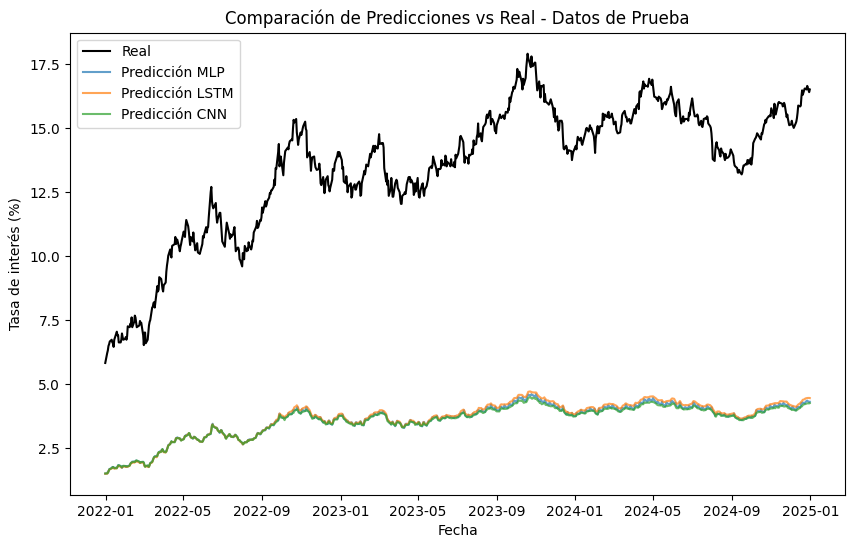

In [ ]:
# Assuming y_test_orig corresponds to the target variable in the test set
# and needs to be reshaped to match the length of the test_df index:

# Reshape y_test_orig to match test_df.index length
# y_test_orig = y_test_orig[:len(test_df)] # This line is incorrect and should be removed
# Instead, slice the test_df to match the length of y_test_orig:
test_df = test_df[:len(y_test_orig)]

# Graficar las predicciones vs reales para un subconjunto del periodo de prueba
plt.figure(figsize=(10, 6))
plt.plot(test_df.index, y_test_orig, label='Real', color='black')
plt.plot(test_df.index, pred_test_mlp_orig, label='Predicción MLP', alpha=0.7)  # No need to slice here
plt.plot(test_df.index, pred_test_lstm_orig, label='Predicción LSTM', alpha=0.7)  # No need to slice here
plt.plot(test_df.index, pred_test_cnn_orig, label='Predicción CNN', alpha=0.7)  # No need to slice here
plt.legend()
plt.title('Comparación de Predicciones vs Real - Datos de Prueba')
plt.xlabel('Fecha')
plt.ylabel('Tasa de interés (%)')
plt.show()

Esta gráfica mostra la curva real de la tasa en el periodo de prueba y las curvas estimadas por cada modelo. Si los modelos han aprendido bien, las curvas de predicción deberían seguir de cerca a la real. Si un modelo es deficiente, veremos su curva desviarse sistemáticamente o ser más errática.